## Load M3CV Dataset

In [5]:
import os
import pandas as pd
from sklearn.utils import shuffle

os.chdir('D:\EEG-ESRT\Datasets\M3CV')

# 读取数据
train_images = pd.read_csv('Enrollment_Info.csv')
val_images = pd.read_csv('Calibration_Info.csv')

train_images = shuffle(train_images, random_state=0)
val_images = shuffle(val_images)

df = train_images

train_img_list = train_images['EpochID'].values
train_label_list = train_images['subject'].values


val_img_list = val_images['EpochID'].values
val_label_list = val_images['SubjectID'].values

print(train_img_list,train_label_list)

['epoch044960' 'epoch026979' 'epoch035645' ... 'epoch042614' 'epoch043568'
 'epoch002733'] ['sub074' 'sub045' 'sub059' ... 'sub070' 'sub072' 'sub005']


In [19]:
train_images

,EpochID,subject,session,condition,usage
44959,epoch044960,sub074,1,7,1
26978,epoch026979,sub045,1,3,1
35644,epoch035645,sub059,1,10,1
36966,epoch036967,sub061,1,8,1
50637,epoch050638,sub084,1,12,1
...,...,...,...,...,...
45891,epoch045892,sub076,1,11,1
52416,epoch052417,sub087,1,11,1
42613,epoch042614,sub070,1,1,1
43567,epoch043568,sub072,1,5,1


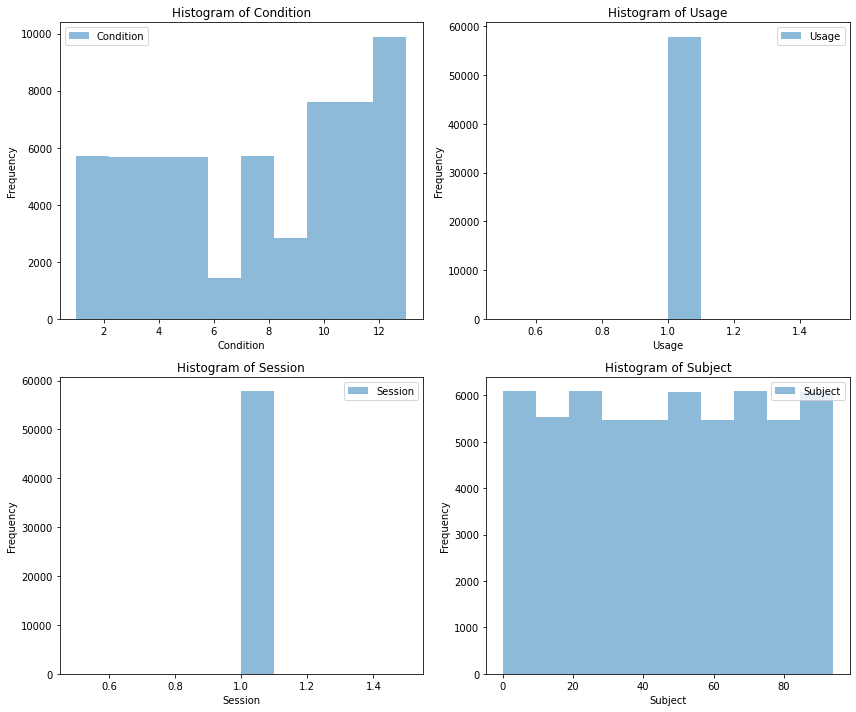

In [9]:
import matplotlib.pyplot as plt

# 假设 train_images 是一个已经存在的 DataFrame
# train_images = pd.read_csv('path_to_your_csv_file.csv')  # 如果需要从CSV文件读取

plt.figure(figsize=(12, 10))

# 绘制 condition 的直方图
plt.subplot(2, 2, 1)
plt.hist(train_images['condition'], alpha=0.5, label='Condition')
plt.xlabel('Condition')
plt.ylabel('Frequency')
plt.title('Histogram of Condition')
plt.legend()

# 绘制 usage 的直方图
plt.subplot(2, 2, 2)
plt.hist(train_images['usage'], alpha=0.5, label='Usage')
plt.xlabel('Usage')
plt.ylabel('Frequency')
plt.title('Histogram of Usage')
plt.legend()

# 绘制 session 的直方图
plt.subplot(2, 2, 3)
plt.hist(train_images['session'], alpha=0.5, label='Session')
plt.xlabel('Session')
plt.ylabel('Frequency')
plt.title('Histogram of Session')
plt.legend()

# 绘制 subject 的直方图
plt.subplot(2, 2, 4)
subjects = train_images['subject'].astype('category').cat.codes
plt.hist(subjects, alpha=0.5, label='Subject')
plt.xlabel('Subject')
plt.ylabel('Frequency')
plt.title('Histogram of Subject')
plt.legend()

# 显示图像
plt.tight_layout()  # 调整子图布局
plt.show()


## Baseline CNN Model For M3CV Dataset

In [16]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
import scipy.io as sio
import os
import numpy as np


# 检查是否有可用的 GPU
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"有可用的 GPU：{torch.cuda.get_device_name(0)}")
else:
    device = torch.device("cpu")
    print("没有可用的 GPU，使用 CPU。")

    



有可用的 GPU：NVIDIA GeForce RTX 2060


In [36]:
class EEGDataset(Dataset):
    def __init__(self, img_list, labels, root_dir='D:\EEG-ESRT\Datasets\M3CV', dataset_type='Enrollment', transform=None):
        """
        img_list: 文件名列表（例如：['epoch044960', 'epoch026979', ...]）
        labels: 对应的标签列表（例如：['sub074', 'sub045', ...]）
        root_dir: 数据集根目录（例如：'./EEG-ESRT/Datasets/M3CV'）
        dataset_type: 'Enrollment' 或 'Calibration' 或 'Testing'，根据数据集类型决定前缀
        transform: 可选的转换操作
        """
        self.img_list = img_list
        self.labels = [int(s.replace("sub", ""))-1 for s in labels]
        self.root_dir = root_dir
        self.dataset_type = dataset_type
        self.transform = transform

    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, idx):
        file_name = self.img_list[idx]
        mat_path = os.path.join(self.root_dir, self.dataset_type, file_name + '.mat')
        data = sio.loadmat(mat_path)['epoch_data']
        eeg_data = data[:64, :]
        task_type = np.unique(data[64, :])[0]
        label = self.labels[idx]

        if self.transform:
            eeg_data = self.transform(eeg_data)

        return eeg_data, task_type, label


In [37]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=95, num_channels=64, task_size=1):
        super(SimpleCNN, self).__init__()
        self.feature_extractor = nn.Sequential(
            # 假设输入的 EEG 数据是 64 通道，1000 时间点
            # 将其视为 64 个独立的 1D 序列
            nn.Conv1d(num_channels, 32, kernel_size=5, padding=2), # 1D 卷积
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(32, 64, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool1d(2),
            # ... 可以根据需要添加更多层
        )
        
        # 请根据特征提取器的最终输出大小调整此值
        # 假设经过卷积和池化后，时间维度减半
        output_size = 1000 // 4 # 假设通过两次池化，时间维度减半
        self.num_features = 64 * output_size

        # 分类器部分
        self.classifier = nn.Sequential(
            nn.Linear(self.num_features + task_size, 128), # 加入任务描述符
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes),
        )

    def forward(self, x, task_type):
        # x: EEG 数据, task_type: 任务描述符
        x = self.feature_extractor(x)
        x = x.view(x.size(0), -1)  # 将特征图拉平
        x = torch.cat((x, task_type.unsqueeze(1)), dim=1) # 拼接任务描述符
        x = self.classifier(x)
        return x




In [38]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [39]:
import torch.optim as optim
from tqdm import tqdm


# 加载数据集

train_data = EEGDataset(train_img_list, train_label_list, dataset_type='Enrollment')
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)

# 假设 num_epochs 已经定义
num_epochs = 10

# 实例化模型并将其移动到 GPU（如果可用）
model = SimpleCNN()
# model = SimpleCNN().to(device)

# 定义损失函数和优化器
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)  # 使用常见的 Adam 优化器

# 训练循环
for epoch in range(num_epochs):
    # 使用 tqdm 显示训练进度
    loop = tqdm(train_loader, leave=True)
    for eeg_data, task_type, labels in loop:
        # 将数据转移到 GPU (如果使用)
        # eeg_data = eeg_data.to(device)
        # task_type = task_type.to(device)
        # labels = labels.to(device)

        # 计算模型输出
        output = model(eeg_data, task_type)

        # 计算损失
        loss = loss_function(output, labels)

        # 清除之前的梯度
        optimizer.zero_grad()

        # 反向传播和优化
        loss.backward()
        optimizer.step()

        # 更新进度条描述
        loop.set_description(f'Epoch [{epoch+1}/{num_epochs}]')
        loop.set_postfix(loss=loss.item())

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


KeyboardInterrupt: 